# Data Preparation and Explorative Analysis Workbook

## Import libraries and modules

In [2]:
import pandas as pd
import numpy as np
import html
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

## 1 - Data Cleaning

In [3]:
# Read in the training data
train_df = pd.read_json('../data/lewtun-drug-reviews/train.jsonl', lines=True)
train_df.sample(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
95056,215085,Fexofenadine,Urticaria,"""Best relief for hives. Prefer this over Xyzal.""",9,2014-02-28,26
145335,142719,Levonorgestrel,Birth Control,"""The mirena iud has changed my life. I have PC...",9,2017-08-09,4
2580,21714,Guaifenesin / pseudoephedrine,Cough and Nasal Congestion,"""Have not had sleep for two nights because of ...",10,2015-01-15,21
119794,177498,Duloxetine,Generalized Anxiety Disorde,"""I&#039;ve just been on 60mg for 4 weeks and t...",8,2016-02-24,82
82803,127130,Metoclopramide,Migraine,"""I just wanted to say as someone who suffered ...",1,2016-10-12,13


In [4]:
# Check for data types and missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  int64         
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 8.6+ MB


In [5]:
# Check for duplicated id
train_df.duplicated(subset=['Unnamed: 0']).sum()

0

In [6]:
# Decode HTML entities back to original characters and remove whitespaces
train_df['review'] = train_df['review'].apply(html.unescape).str.replace(r'[\r\n\t]', '', regex=True).str.strip()
#train_df['condition'] = train_df['condition'].apply(lambda x: html.unescape(x) if x is not None else None)

In [7]:
# Check out wrong condition values
train_df[train_df.condition.notna() & train_df.condition.str.contains('users found this comment helpful')]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I'm 16 and I have been on Loestrin 24 for ab...",3,2010-11-03,2
196,67383,Provera,4</span> users found this comment helpful.,"""I'm 24 years old and have always had a pretty...",1,2016-03-27,4
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
264,132965,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2,2014-06-24,4
391,91050,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9,2009-03-15,11
...,...,...,...,...,...,...,...
160322,173464,Alli,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki...",9,2015-04-02,99
160791,150010,Soma,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T...",5,2010-03-11,62
160899,209239,Geodon,7</span> users found this comment helpful.,"""I've been taking Geodon for about a month or ...",7,2011-02-04,7
160921,96527,Neurontin,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """,9,2013-07-08,92


In [8]:
# Remove wrong condition values and keep the rows
train_df.loc[train_df.condition.notna() & train_df.condition.str.contains('users found this comment helpful'), 'condition'] = None

In [9]:
# Check out rows with missing condition values
train_df[train_df.condition.isna()]

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
30,51452,Azithromycin,None,"""Very good response. It is so useful for me. """,10,2010-08-18,1
105,220696,Loestrin 24 Fe,None,"""I'm 16 and I have been on Loestrin 24 for ab...",3,2010-11-03,2
148,61073,Urea,None,"""Accurate information.""",10,2011-07-02,13
196,67383,Provera,None,"""I'm 24 years old and have always had a pretty...",1,2016-03-27,4
243,81588,Yaz,None,"""I took Yaz for a little over 2 years. From a...",3,2010-06-01,3
...,...,...,...,...,...,...,...
160791,150010,Soma,None,"""I am sharing a painful experience actually. T...",5,2010-03-11,62
160841,150516,Sulfamethoxazole / trimethoprim,None,"""Given a 7 day course. After 2 days, insomnia,...",4,2016-09-28,3
160899,209239,Geodon,None,"""I've been taking Geodon for about a month or ...",7,2011-02-04,7
160921,96527,Neurontin,None,"""At 300mg 4x daily my pain was almost gone. """,9,2013-07-08,92


## 2 - Explorative Data Analysis

In [10]:
# Check the unique values of categorical variables
print(train_df.drugName.value_counts())
print('-' * 65)
print(train_df.condition.value_counts())

drugName
Levonorgestrel                       3657
Etonogestrel                         3336
Ethinyl estradiol / norethindrone    2850
Nexplanon                            2156
Ethinyl estradiol / norgestimate     2117
                                     ... 
Omnipaque 350                           1
Vontrol                                 1
Ivabradine                              1
Neo-Poly-Dex                            1
Grifulvin V                             1
Name: count, Length: 3436, dtype: int64
-----------------------------------------------------------------
condition
Birth Control              28788
Depression                  9069
Pain                        6145
Anxiety                     5904
Acne                        5588
                           ...  
Strongyloidiasis               1
Esophageal Spasm               1
Somatoform Pain Disorde        1
Portal Hypertension            1
Neutropenia                    1
Name: count, Length: 811, dtype: int64


<Axes: title={'center': 'Drug Name Distribution'}, ylabel='drugName'>

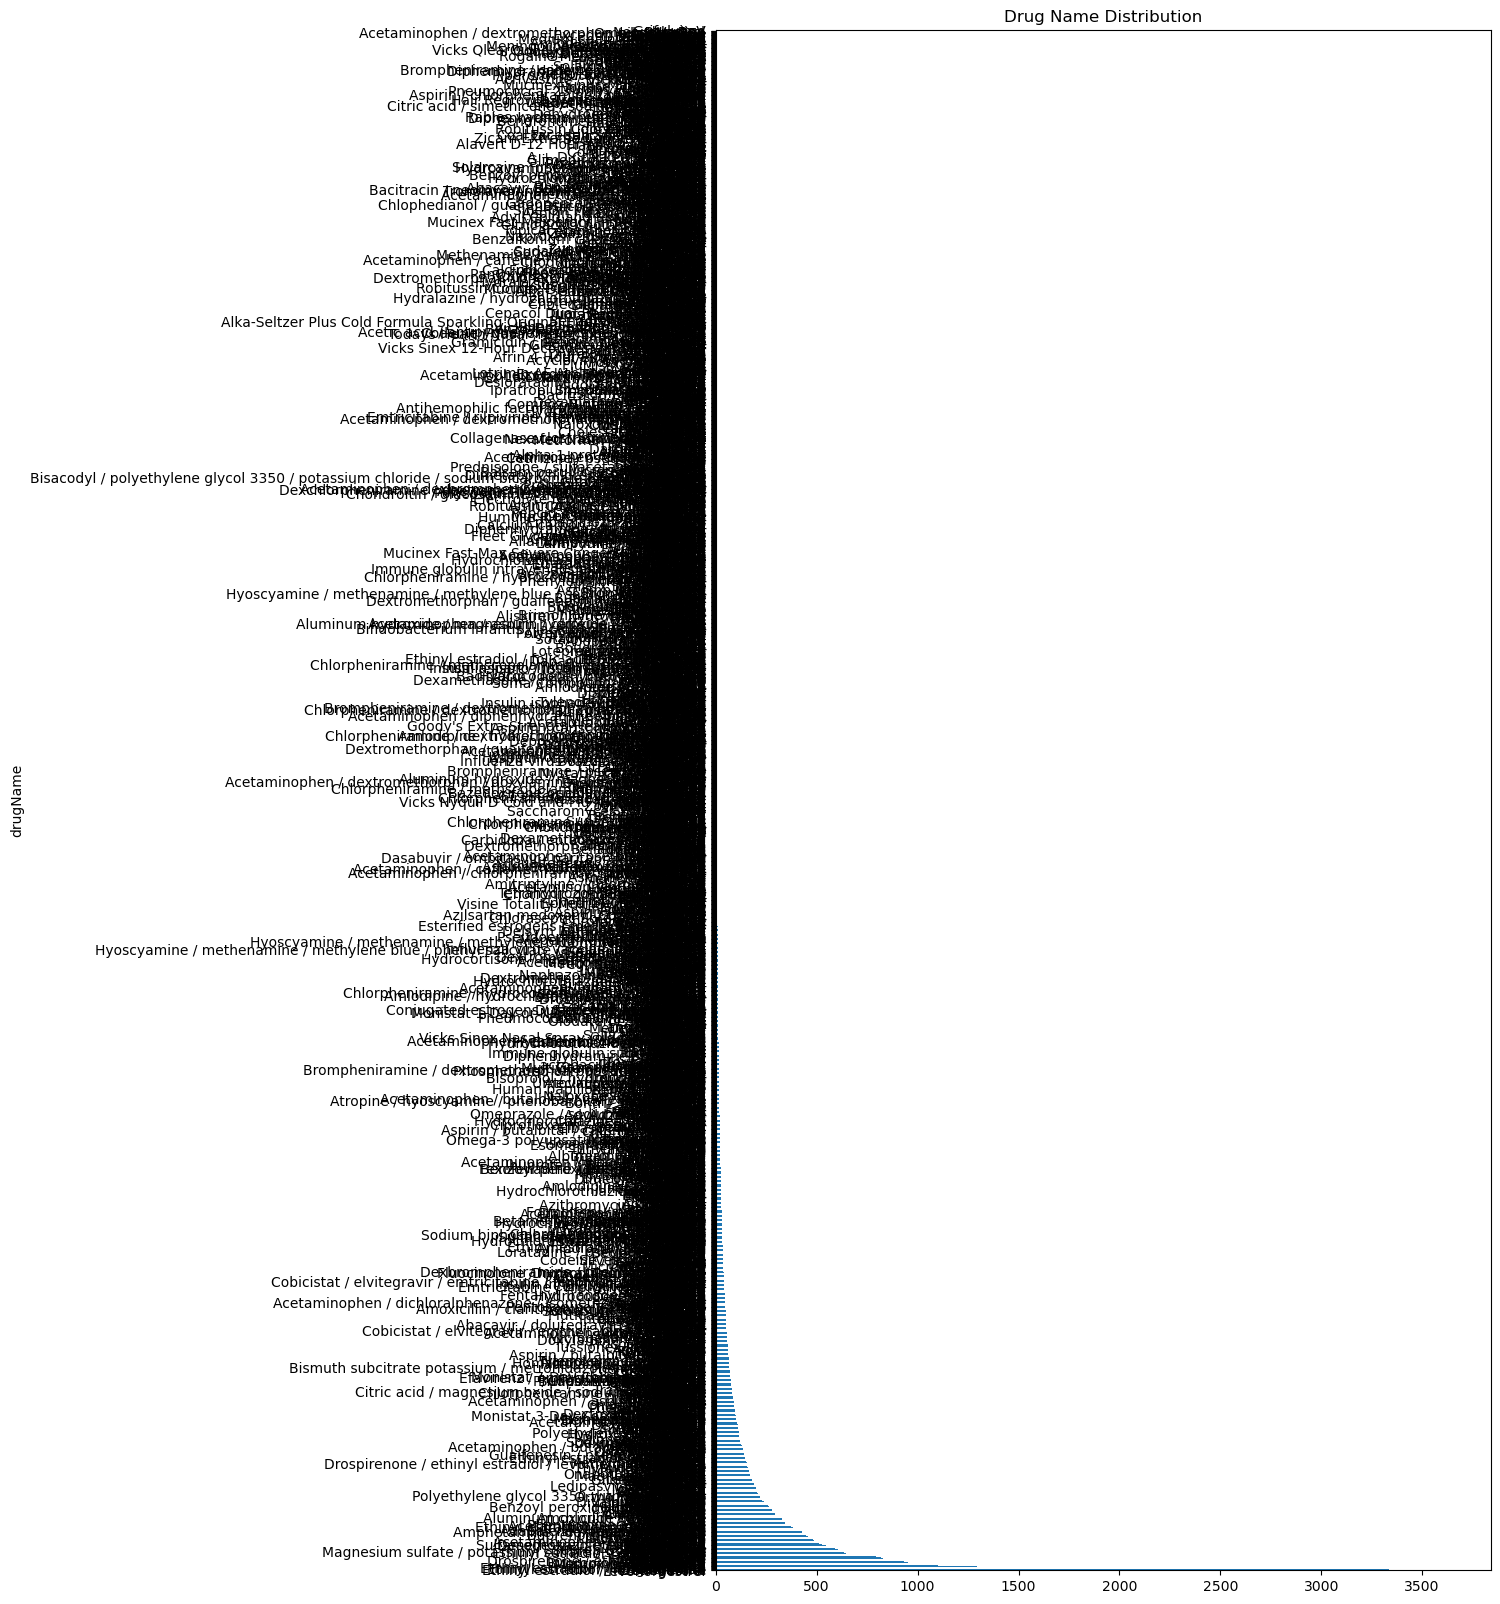

In [11]:
train_df.drugName.value_counts().plot(kind='barh', figsize=(10, 20), title='Drug Name Distribution')

<Axes: title={'center': 'Condition Distribution'}, ylabel='condition'>

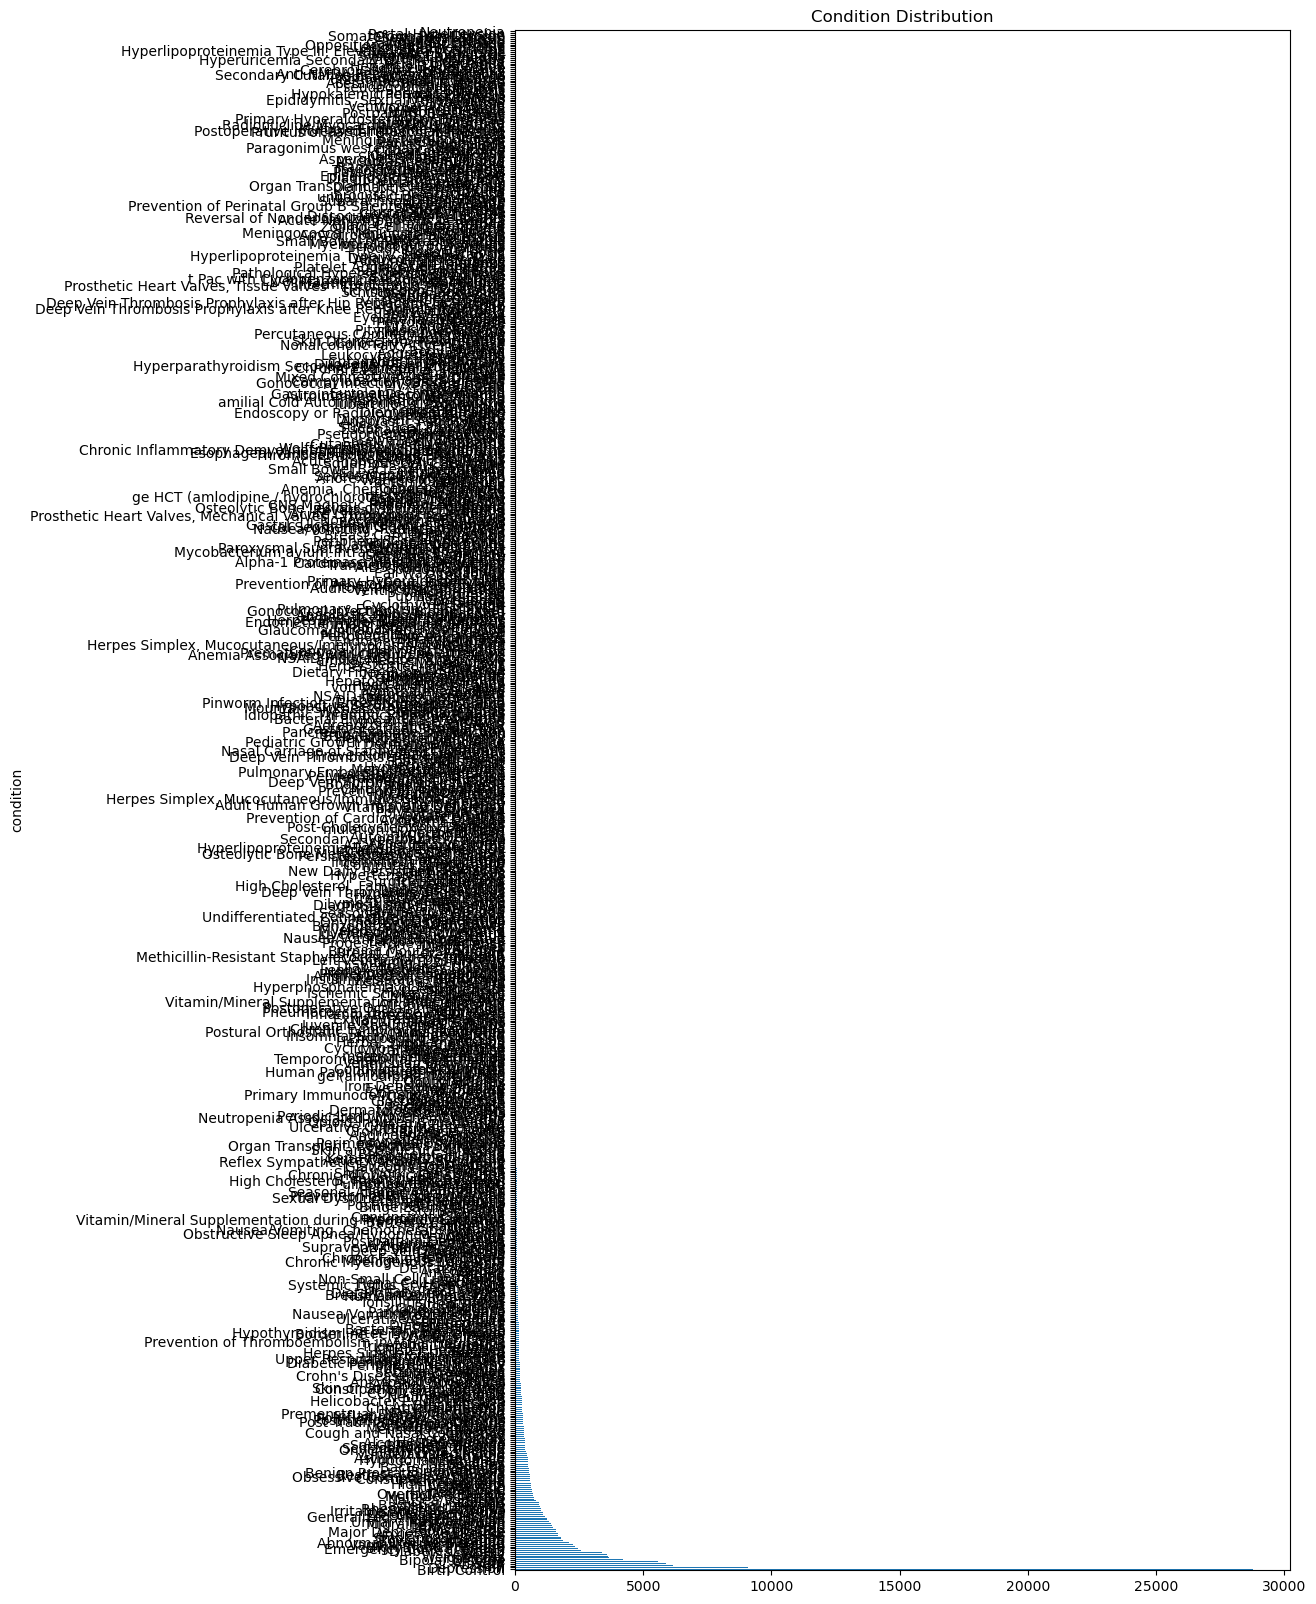

In [12]:
train_df.condition.value_counts().plot(kind='barh', figsize=(10, 20), title='Condition Distribution')

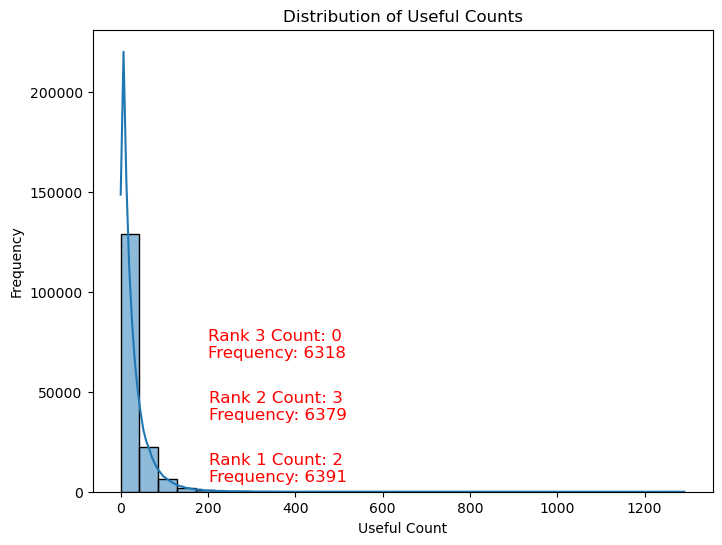

In [13]:
# Visualize the distribution of drug reviews' ratings
plt.figure(figsize=(8, 6))
sns.histplot(train_df['usefulCount'], bins=30, kde=True)
plt.xlabel('Useful Count')
plt.ylabel('Frequency')
plt.title('Distribution of Useful Counts')

# Find the top three most frequent Useful Counts and their frequency counts
most_frequent_counts = train_df['usefulCount'].value_counts().nlargest(3)
top_counts = most_frequent_counts.index
top_counts_freq = most_frequent_counts.values

# Add the top three most frequent Useful Counts and their frequency counts as text to the figure
text_spacing = 31000  # Adjust this value to control the vertical spacing between text lines
for i in range(3):
    x_pos = top_counts[i] + 200
    y_pos = 5000 + i * text_spacing
    text = f'Rank {i+1} Count: {top_counts[i]}\nFrequency: {top_counts_freq[i]}'
    plt.text(x_pos, y_pos, text, fontsize=12, color='red')

plt.show()

Q: count 0 is 6318? how to interpret it?

A: Limited Impact: The review may not have provided significant value or information to other users. It might be a less-detailed or less-informative review.

Reviewer's Intent: Some users may not actively seek or expect to receive "useful" votes on their reviews. They may simply be sharing their experiences or opinions without aiming for high "usefulCount" numbers.

leading our analysis direction to focus on text analysis?

In [14]:
# Group the data by 'condition' and 'drugName', calculate the average rating, and count the reviews
condition_drug_stats = train_df.groupby(['condition', 'drugName']).agg({'rating': 'mean', 'review': 'count'}).reset_index()

# Sort by condition and review count, and select the top 5 drugs for each condition
top5_drugs_by_condition = condition_drug_stats.sort_values(['condition', 'review'], ascending=[True, False]).groupby('condition').head(5)

# Count the occurrences of each condition in the dataset
condition_counts = train_df['condition'].value_counts()

# Select the top three conditions with the highest counts
top3_conditions = condition_counts.index[:3]

# Group by 'condition' and print the top 5 drugs, their counts, and average ratings for the top 3 conditions
for condition in top3_conditions:
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    print(f"Condition: {condition}")
    for _, row in condition_data.iterrows():
        print(f"  Drug: {row['drugName']} - Count: {row['review']} - Average Rating: {row['rating']:.2f}")
    print()


Condition: Birth Control
  Drug: Etonogestrel - Count: 3314 - Average Rating: 5.81
  Drug: Ethinyl estradiol / norethindrone - Count: 2337 - Average Rating: 5.66
  Drug: Nexplanon - Count: 2149 - Average Rating: 5.68
  Drug: Levonorgestrel - Count: 2129 - Average Rating: 7.06
  Drug: Ethinyl estradiol / levonorgestrel - Count: 1600 - Average Rating: 5.90

Condition: Depression
  Drug: Bupropion - Count: 549 - Average Rating: 7.36
  Drug: Sertraline - Count: 459 - Average Rating: 7.17
  Drug: Venlafaxine - Count: 437 - Average Rating: 6.48
  Drug: Pristiq - Count: 418 - Average Rating: 7.19
  Drug: Desvenlafaxine - Count: 414 - Average Rating: 7.24

Condition: Pain
  Drug: Tramadol - Count: 357 - Average Rating: 6.51
  Drug: Acetaminophen / hydrocodone - Count: 332 - Average Rating: 7.98
  Drug: Oxycodone - Count: 281 - Average Rating: 8.86
  Drug: Acetaminophen / oxycodone - Count: 249 - Average Rating: 8.55
  Drug: Tapentadol - Count: 216 - Average Rating: 6.33



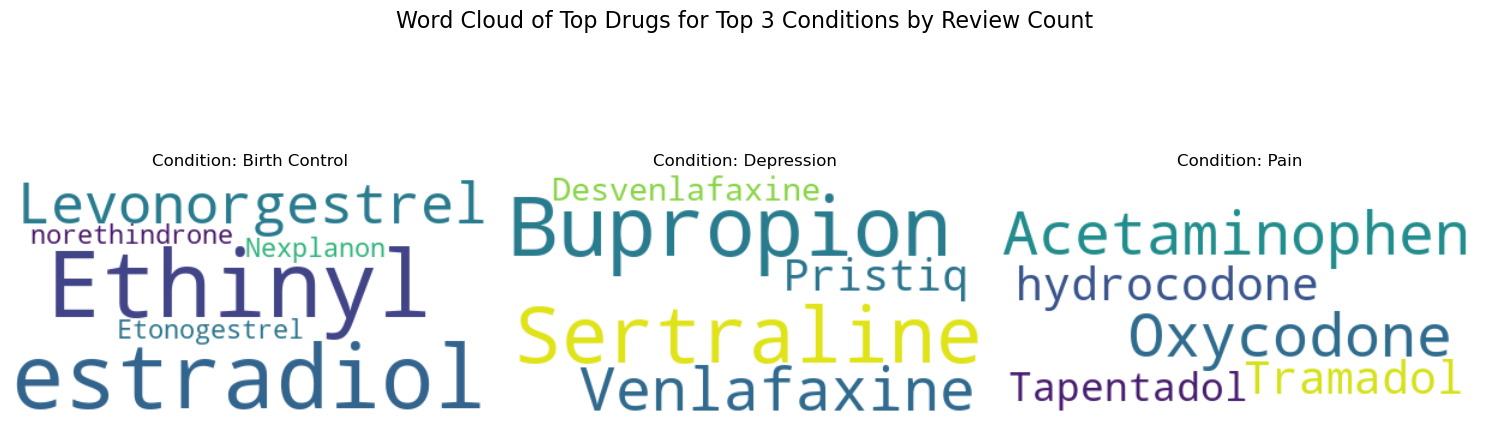

In [15]:
# Create a word cloud for the top drugs for each of the top 3 conditions
plt.figure(figsize=(15, 5))
for i, condition in enumerate(top3_conditions, 1):
    plt.subplot(1, 3, i)
    
    # Filter data for the current condition
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    
    # Get the top drugs for the current condition
    top_drugs = condition_data['drugName']
    
    # Create a word cloud for the top drugs
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(top_drugs))
    
    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Condition: {condition}')
    plt.axis('off')

plt.suptitle('Word Cloud of Top Drugs for Top 3 Conditions by Review Count', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


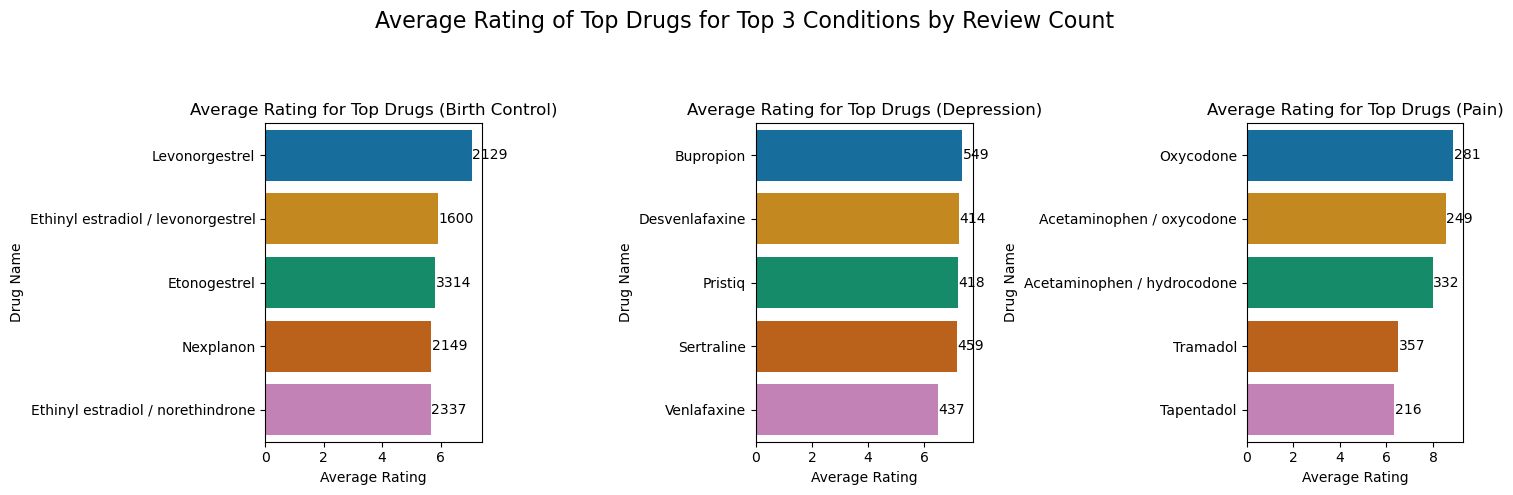

In [16]:
# Create a color palette with distinct colors
colors = sns.color_palette("colorblind", n_colors=15)

# Create a bar chart for average ratings of the top drugs for the top 3 conditions
plt.figure(figsize=(15, 5))
for i, condition in enumerate(top3_conditions, 1):
    plt.subplot(1, 3, i)
    
    # Filter data for the current condition
    condition_data = top5_drugs_by_condition[top5_drugs_by_condition['condition'] == condition]
    
    # Order drugs based on average rating
    condition_data = condition_data.sort_values(by='rating', ascending=False)
    
    # Create a bar chart for average ratings with unique colors for each drug
    bar_plot = sns.barplot(data=condition_data, x='rating', y='drugName', palette=colors)
    
    # Add the count as text at the end of each bar
    for index, row in enumerate(condition_data.iterrows(), start=1):
        bar_plot.text(row[1]['rating'] + 0.02, index - 1, f'{row[1]["review"]}', va='center', fontsize=10)
    
    plt.xlabel('Average Rating')
    plt.ylabel('Drug Name')
    plt.title(f'Average Rating for Top Drugs ({condition})')
    plt.tight_layout()

plt.suptitle('Average Rating of Top Drugs for Top 3 Conditions by Review Count', fontsize=16)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.9))
plt.show()


<Axes: title={'center': 'Rating Density Plot'}, ylabel='Density'>

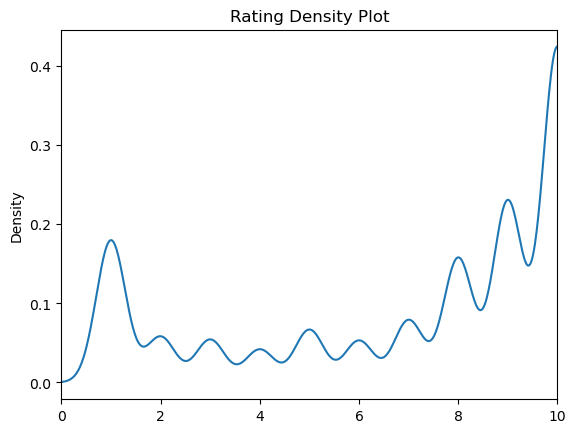

In [17]:
train_df.rating.plot(kind='density', title='Rating Density Plot', xlabel='Value', ylabel='Density', xlim=(0, 10))

<Axes: title={'center': 'Rating Density Plot for rows with missing condition values'}, ylabel='Density'>

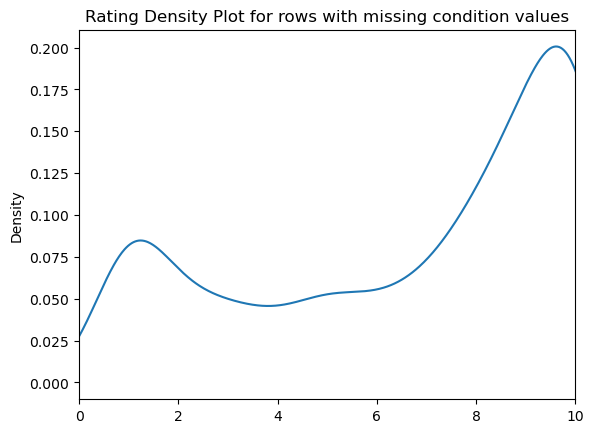

In [18]:
# Check out rating distribution for rows with missing condition values
#print(train_df[train_df.condition.isna()].rating.value_counts())

train_df[train_df.condition.isna()].rating.plot(
    kind='density',
    title='Rating Density Plot for rows with missing condition values',
    xlabel='Value', ylabel='Density', xlim=(0, 10)
)

The above plot shows that samples with missing condition values have an similar distribution with the whole dataset.

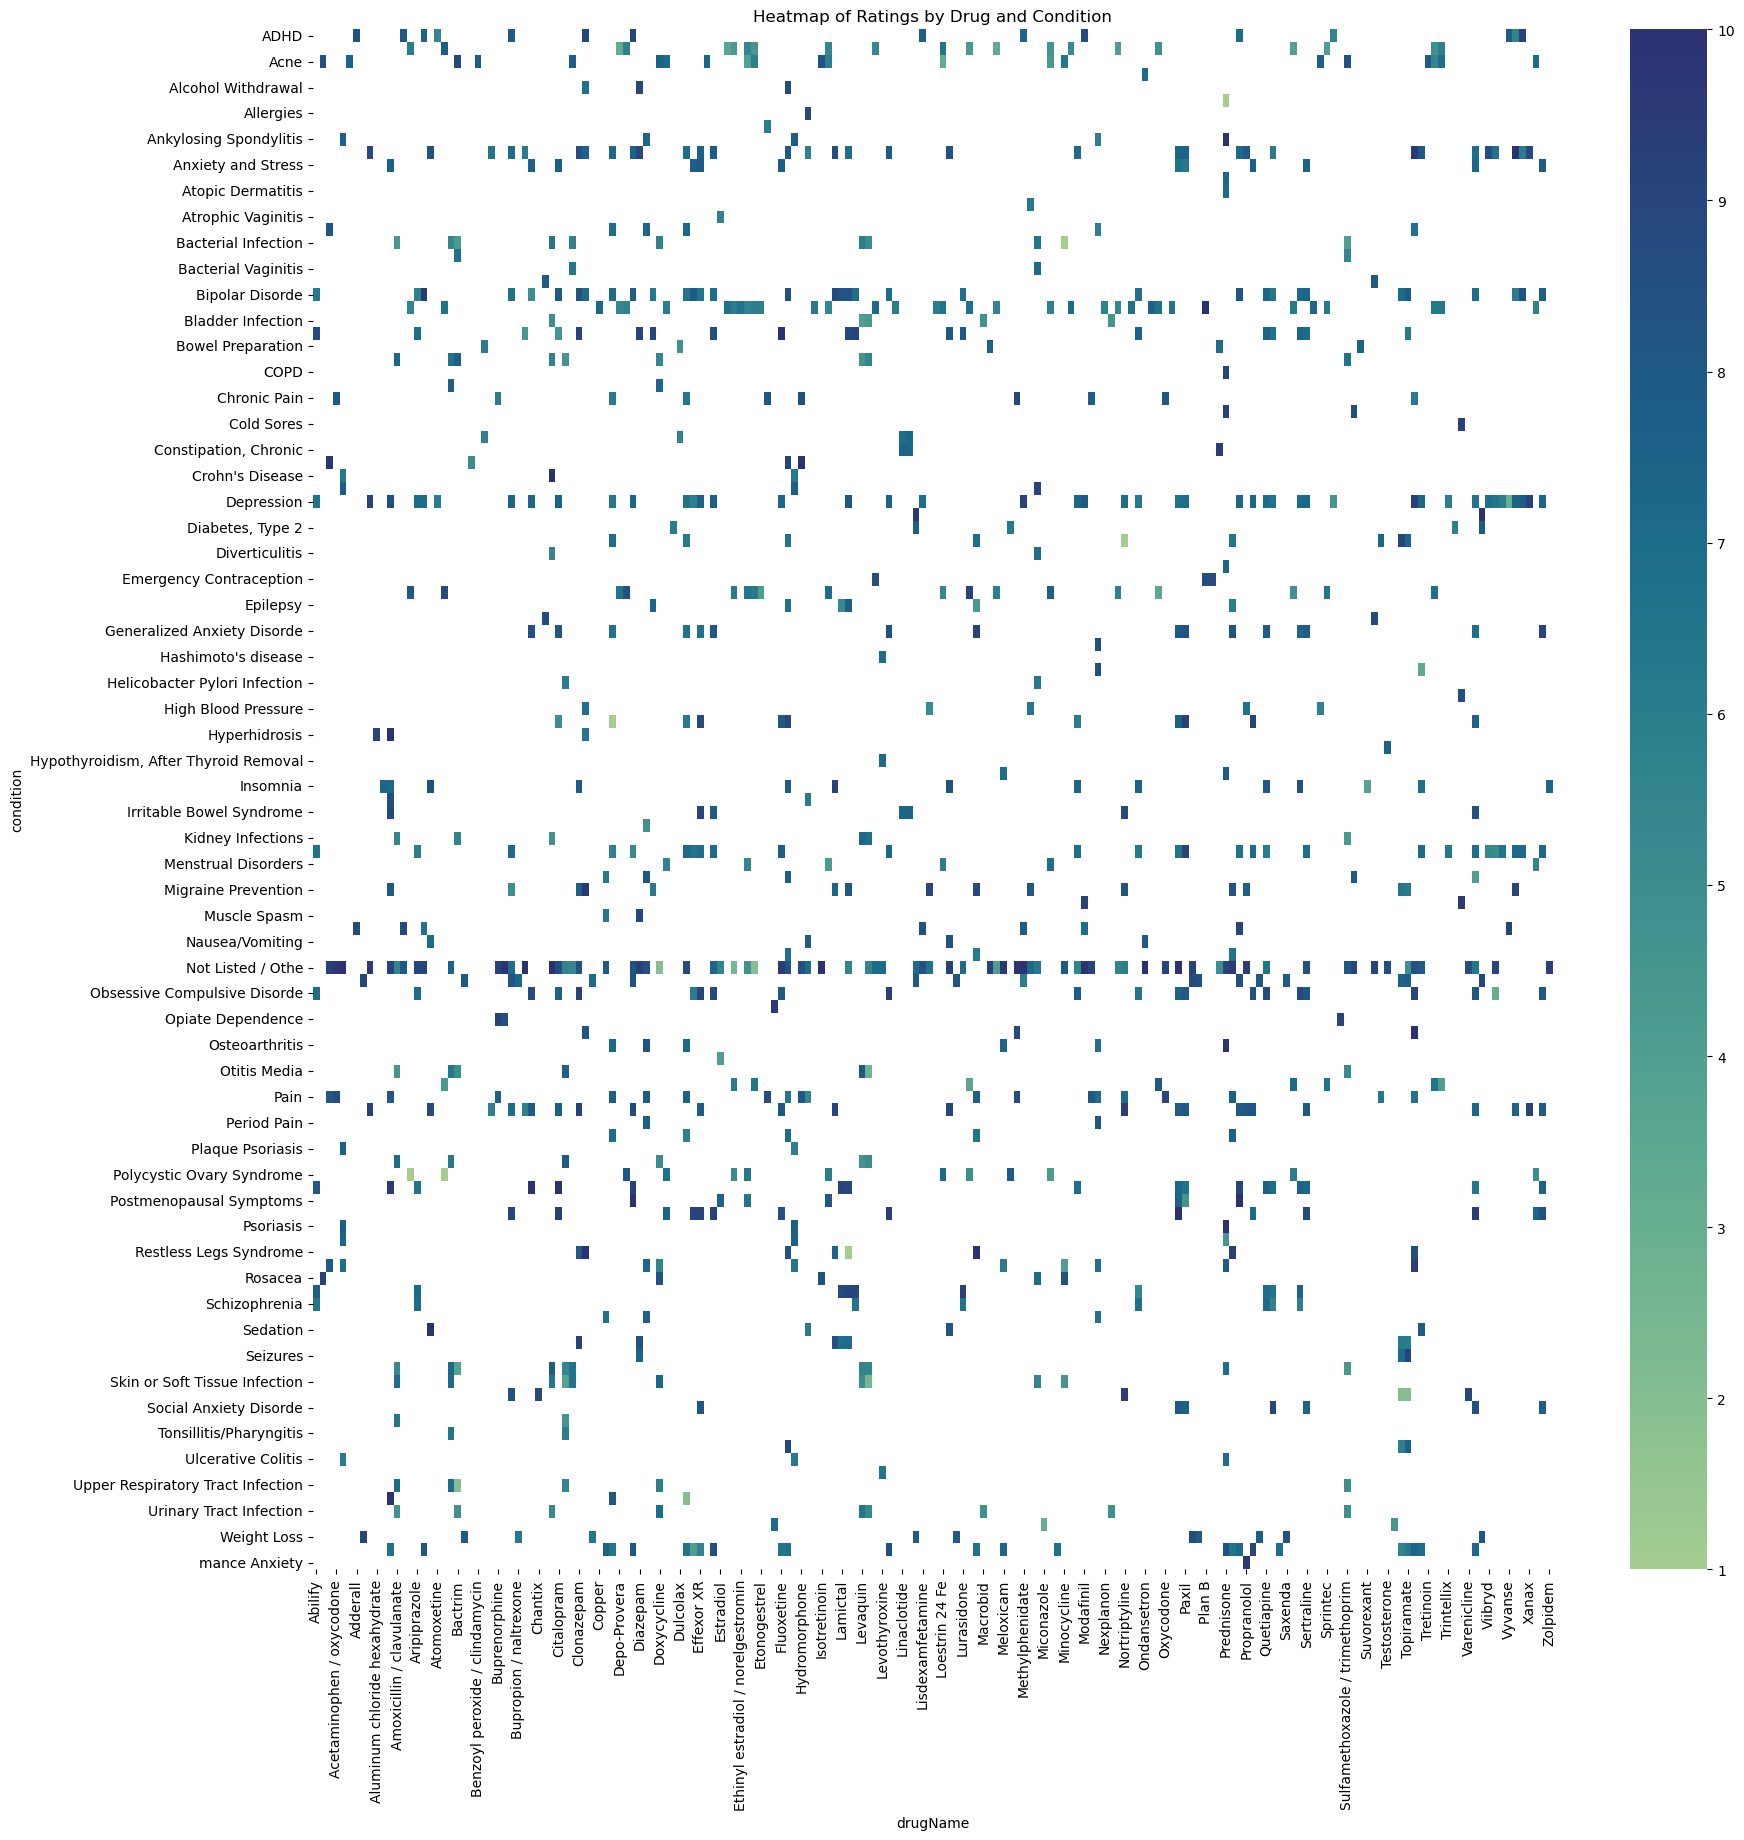

In [19]:
# Heatmap of Ratings by drugName and condition

freq_drugName = train_df.drugName.value_counts()[train_df.drugName.value_counts().ge(200)].index
freq_condition = train_df.condition.value_counts()[train_df.condition.value_counts().ge(100)].index

agg_df = train_df[train_df.drugName.isin(freq_drugName) & train_df.condition.isin(freq_condition)].groupby(['drugName', 'condition']).rating.mean().reset_index()
pivot_df = pd.pivot_table(agg_df, values='rating', index='condition', columns='drugName')

plt.figure(figsize=(20, 20))
sns.heatmap(pivot_df, annot=False, fmt='.0f', cbar=True, cmap='crest')
plt.title('Heatmap of Ratings by Drug and Condition')
plt.xlabel('drugName')
plt.ylabel('condition')
plt.show()

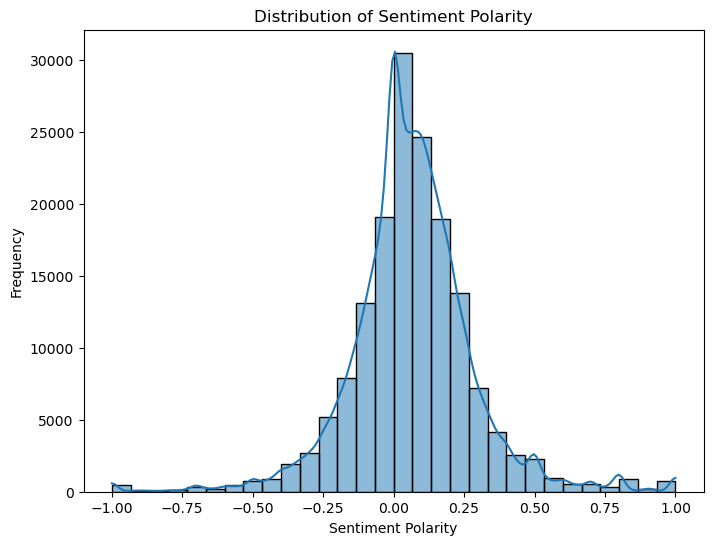

In [20]:
# Create a function to get sentiment polarity
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the review text
train_df['sentiment_polarity']=train_df['review'].apply(get_sentiment_polarity)

# Visualize the sentiment polarity distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentiment_polarity'], bins=30, kde=True)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()

## 3 - Extract Sample Subset of Train Data

Extract a preliminary evaluation to select a model before committing to the more time-consuming process of training and hyperparameter tuning on the full dataset.

For statistical significance, a stratified random sampling will be implemented to extract 20% of the training data as the sample subset.

Since the supervised learning task is to predict the `rating`, the stratification will be done by `rating`.

In [21]:
# 
X_train = train_df.iloc[:, 1:].drop('rating', axis=1)
y_train = train_df.rating

print(f'X_train shape: {X_train.shape}')
print(f'X_train columns: {X_train.columns}')
print('')
print(f'y_train shape: {y_train.shape}')

X_train shape: (161297, 6)
X_train columns: Index(['drugName', 'condition', 'review', 'date', 'usefulCount',
       'sentiment_polarity'],
      dtype='object')

y_train shape: (161297,)


In [22]:
# Sample 20% of the training data for preliminary model evaluation, stratified by y_train
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.8, random_state=42)

print(f'X_sample shape: {X_sample.shape}')
print(f'X_sample columns: {X_sample.columns}')
print('')
print(f'y_sample shape: {y_sample.shape}')

X_sample shape: (32259, 6)
X_sample columns: Index(['drugName', 'condition', 'review', 'date', 'usefulCount',
       'sentiment_polarity'],
      dtype='object')

y_sample shape: (32259,)


In [23]:
# Save the sample subset of training data to disk
#X_sample.to_csv('../data/raw/lewtun-drug-reviews/X_sample.csv', index=False)
#y_sample.to_csv('../data/raw/lewtun-drug-reviews/y_sample.csv', index=False)

## 4 - Text Preprocessing and Feature Engineering

### 4.1 - Libraries for Text Preprocessing and Feature Engineering

In [24]:
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer

### 4.2 - Text Preprocessing

In [25]:
train_df['review'] = train_df['review'].str.lower()

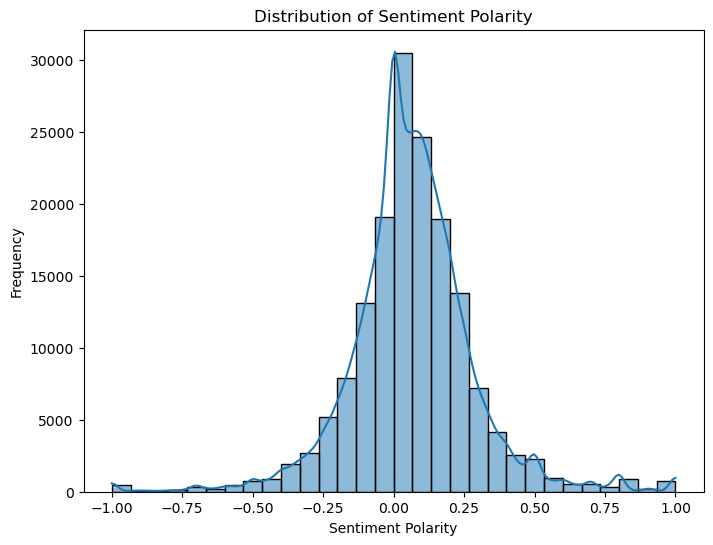

In [26]:
# Create a function to get sentiment polarity
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the review text
train_df['sentiment_polarity']=train_df['review'].apply(get_sentiment_polarity)

# Visualize the sentiment polarity distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_df['sentiment_polarity'], bins=30, kde=True)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()

### 4.3 - Tokenization: Split the text into individual words or tokens.

In [27]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import contractions
import spacy

In [150]:
# Initialize TweetTokenizer and WordNetLemmatizer
tweet_tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
# Load the spaCy English language model
#nlp = spacy.load("en_core_web_sm")

# Function to tokenize, preserving specific terms in 'drugName' and 'condition'
def tokenize_review_with_entities(review, drug_name, condition):
    # Combine numbers and units/dates/times without space
    review = re.sub(r'(\d+)\s*([mgGsdMy])', r'\1\2', review)
    # Remove stray quotation marks at the beginning and end
    review = re.sub(r'^"+|"+$', '', review)
    # Expand contractions
    review = contractions.fix(review)

    # If condition has a space or comma, replace it with a placeholder
    if condition and (' ' in condition or ',' in condition):
        condition_placeholder = 'CONDITION_'
        review = review.replace(condition.lower(), condition_placeholder)
   
    # Replace 'drugName' and 'condition' terms with placeholders
    if drug_name and condition:
        review_with_placeholders = review.replace(drug_name, 'DRUGNAME').replace(condition, 'CONDITION')
    else:
        review_with_placeholders = review
    
    # Replace 'side effect' with a placeholder
    review_with_placeholders = review_with_placeholders.replace('side effect', 'SIDEEFFECT')

    # Replace 'wa' with 'be'
    review_with_placeholders = review_with_placeholders.replace('wa', 'be')

    # Replace 'ha' with 'have'
    review_with_placeholders = review_with_placeholders.replace('ha', 'have')

    # Replace 'wa' with 'be'
    review_with_placeholders = review_with_placeholders.replace('gained', 'gain')
    review_with_placeholders = review_with_placeholders.replace('eating', 'eat')
    review_with_placeholders = review_with_placeholders.replace('started', 'start')

    # Tokenize the review
    tokenized_review = tweet_tokenizer.tokenize(review_with_placeholders)
    
    # Replace placeholders with original 'drugName' and 'condition' terms
    if drug_name and condition:
        tokenized_review = [word.replace('DRUGNAME', drug_name).replace('CONDITION', condition) for word in tokenized_review]
    # If condition has a space or comma, revert the placeholder to the original condition
    if condition and (' ' in condition or ',' in condition):
        tokenized_review = [word.replace('CONDITION_', condition.lower()) for word in tokenized_review]
    
    # Replace 'SIDEEFFECT' with the original term 'side effect'
    tokenized_review = [word.replace('SIDEEFFECT', 'side effect') for word in tokenized_review]

    # Lemmatize the tokens: Reduce words to their base or root form to standardize variations of words.
    tokenized_review = [lemmatizer.lemmatize(word) for word in tokenized_review]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['day', 'week', 'month', 'year', 'years',
                       'mg', ' mg', 'mg ', 'lb','lbs', ' lbs',
                       'haveve', 'haved', 'thavet', 'haveving','thaven',
                       'taking','take', 'took',
                       'used','using',
                       'got','go','give',
                       
                       ])
    tokenized_review = [word for word in tokenized_review if word.lower() not in stop_words]

    # Remove non-alphabetic characters and digits
    tokenized_review = [re.sub(r'[^a-zA-Z]', '', word) for word in tokenized_review if word]
    # Remove special characters and keep alphanumeric and spaces
    #tokenized_review = [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in tokenized_review]

    # Remove empty tokens
    tokenized_review = [word for word in tokenized_review if word]

    # Process the review using spaCy
   # doc = nlp(review)

    # Tokenize, lemmatize, and remove stop words
    #tokenized_review = [token.lemma_ for token in doc if not token.is_stop]

    return tokenized_review

import spacy
nlp = spacy.load("en_core_web_sm")
def tokenize_review_with_entities(review, drug_name, condition):
    doc = nlp(review)
    tokenized_review = [token.lemma_ for token in doc if not token.is_stop]
    return tokenized_review


In [151]:
# Preprocess and tokenize the 'review' column while preserving 'drugName' and 'condition'
train_df['tokenized_review'] = train_df.apply(lambda row: tokenize_review_with_entities(row['review'], row['drugName'], row['condition']), axis=1)
# Display the DataFrame with tokenized reviews
print(train_df[['review', 'tokenized_review']].head())

In [144]:
print(train_df[['review', 'tokenized_review']].sample(5))

                                                  review  \
11881  "i have been using sertraline for about 3 mont...   
61291  "i had a yi probably in 2011 used monistat 1 s...   
68968  "i started alli on saturday 16th. i took all 3...   
23498  "i was not one prone to headaches until recent...   
30958  "had hep c for many years but didn't worry too...   

                                        tokenized_review  
11881  [sertraline, months, worried, sideeffects, med...  
61291  [yi, probably, monistat, so, quicker, process,...  
68968  [started, alli, saturday, th, pill, throughtou...  
23498  [one, prone, headache, recently, started, base...  
30958  [hep, c, many, worry, much, except, protect, o...  


In [124]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

In [145]:
train_df['tokenized_review_str'] = train_df['tokenized_review'].apply(' '.join)

In [146]:
# Create a CountVectorizer to convert tokens into a bag-of-words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(train_df['tokenized_review_str'])

In [147]:
# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [148]:
# Function to display top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Display top 10 keywords for each topic
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

Topic 0:
infection patch burning eye itching like time use product antibiotic
Topic 1:
sleep mg work night hour time pain medicine help doe
Topic 2:
weight lost started eat pound eating sideeffects food lbs gain
Topic 3:
skin acne face started clear time like work months really
Topic 4:
pain sideeffects blood nausea medication pressure stomach severe headache started
Topic 5:
period pill cramp hour pain time like bleeding days bad
Topic 6:
period pill gain weight birthcontrol months mood time sex acne
Topic 7:
mg feel life started depression like medication years better felt
Topic 8:
anxiety attack sideeffects feel medication panic depression drug like life
Topic 9:
pain migraine doctor work years time drug medicine medication life


In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate coherence using c_v coherence score
from gensim.models import CoherenceModel
from gensim import corpora

In [137]:
# Convert the text data to a list of tokenized words
tokenized_reviews = train_df['tokenized_review'].tolist()

# Build a dictionary and corpus for the LDA model
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# Convert scikit-learn's LDA model to Gensim's LdaModel
gensim_lda_model = LdaModel(
    corpus=corpus,
    num_topics=10,
    id2word=dictionary,
    alpha='auto'
)

# Calculate coherence using c_v coherence
coherence_model_lda_gensim = CoherenceModel(
    model=gensim_lda_model,
    texts=tokenized_reviews,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_lda_gensim = coherence_model_lda_gensim.get_coherence()
print(f'Coherence Score (Gensim LDA): {coherence_lda_gensim}')

Coherence Score (Gensim LDA): 0.5008729823234201


In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


/Users/lai/miniconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


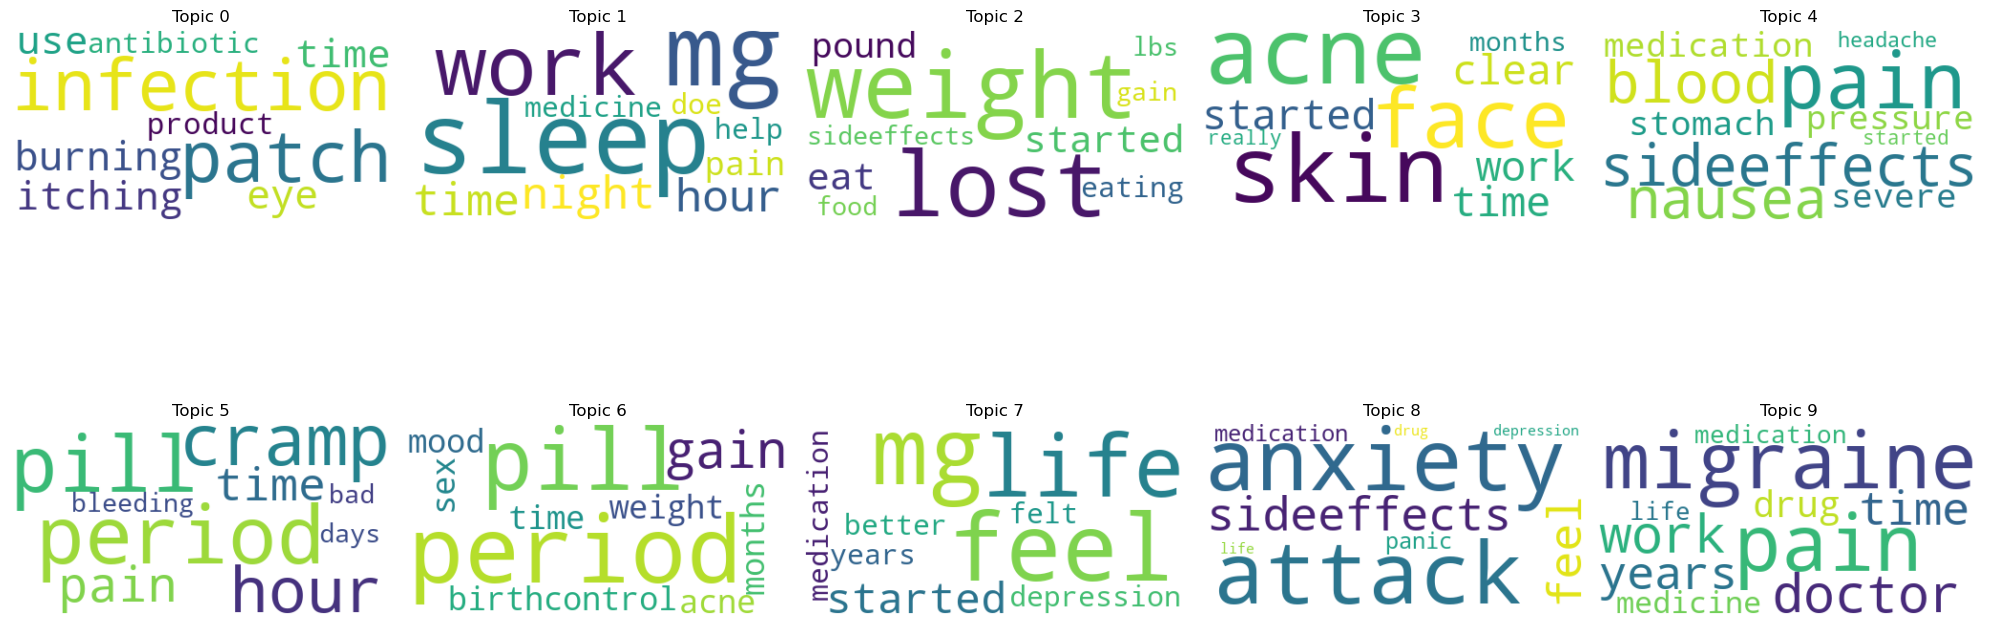

In [149]:
# Create a word cloud for each topic in a grid
def generate_wordclouds_grid(lda_model, feature_names, num_words=10, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

    for topic_idx, ax in enumerate(axes.flat):
        if topic_idx < len(lda_model.components_):
            topic = lda_model.components_[topic_idx]
            wordcloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.axis("off")
            ax.set_title(f'Topic {topic_idx}')

    plt.tight_layout()
    plt.show()

# Generate word clouds for each topic in a grid
generate_wordclouds_grid(lda, feature_names, num_words=10, rows=2, cols=5)


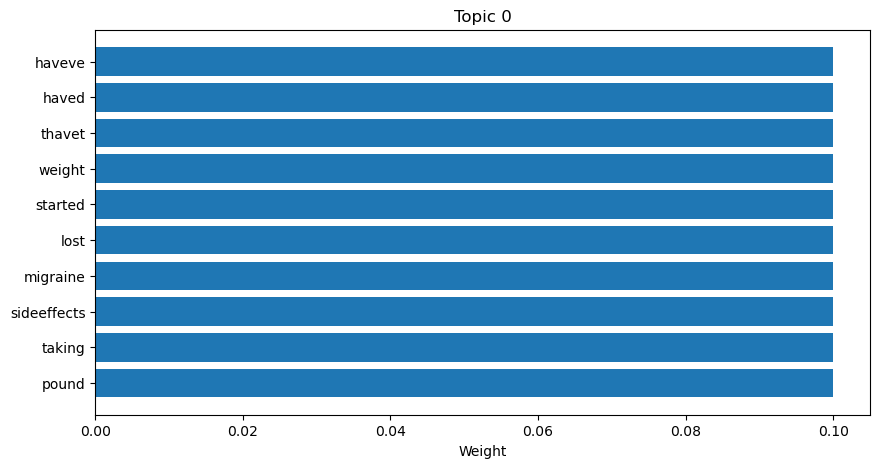

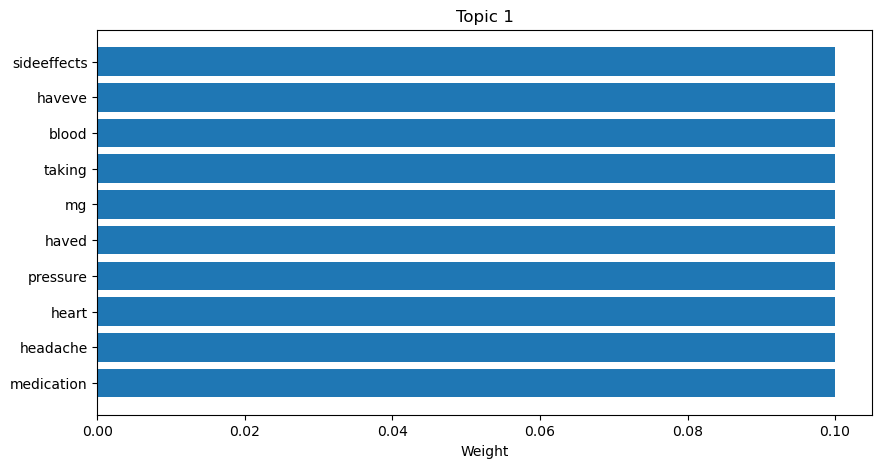

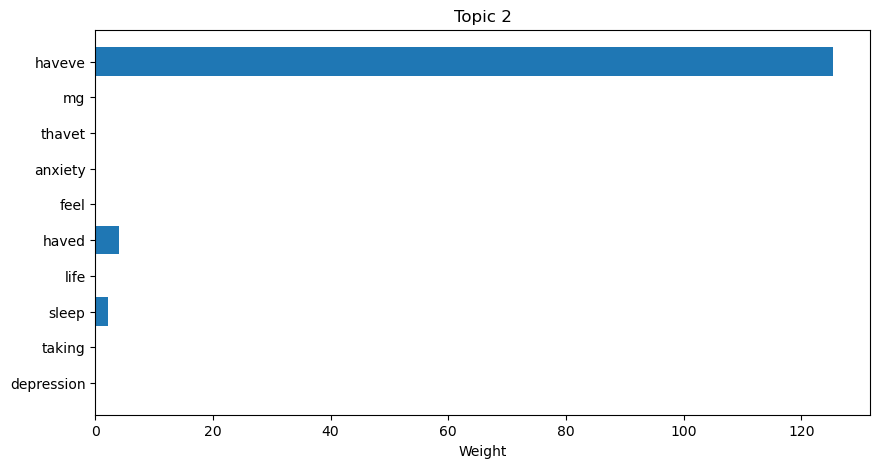

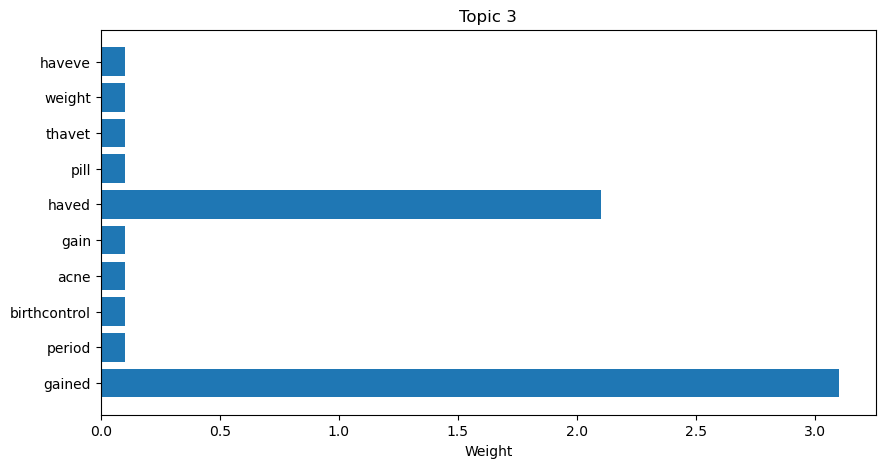

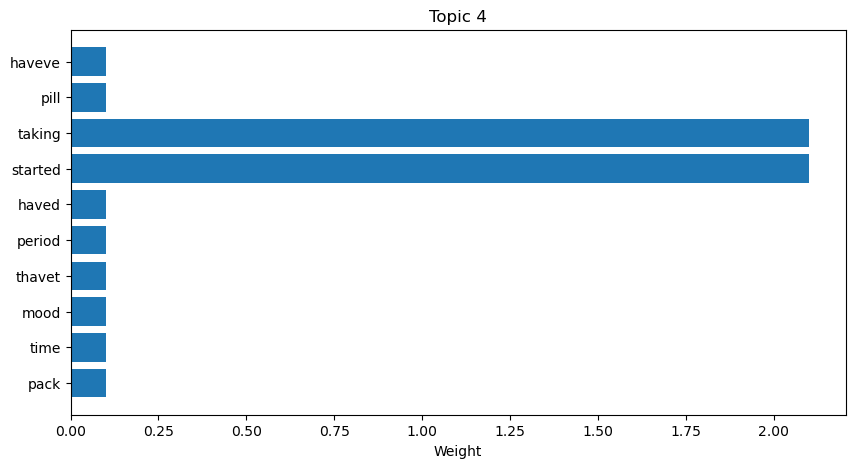

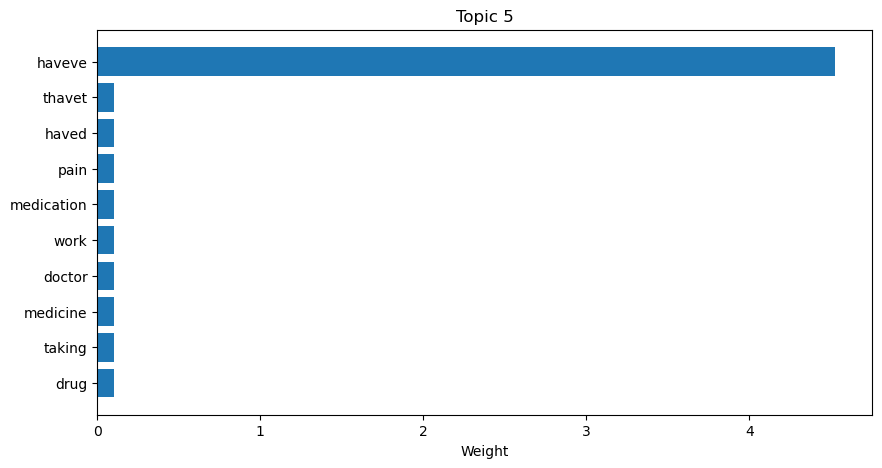

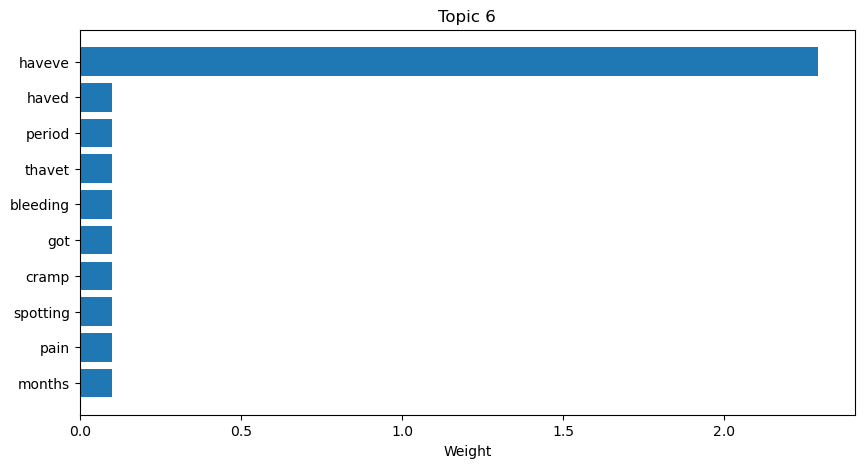

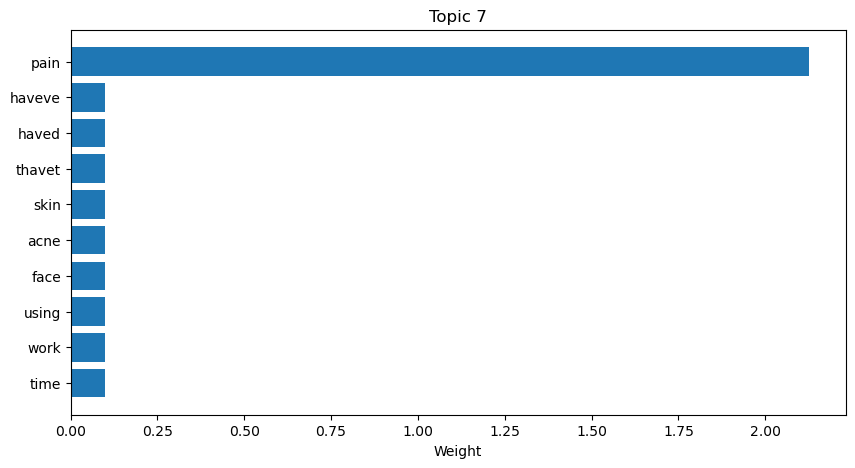

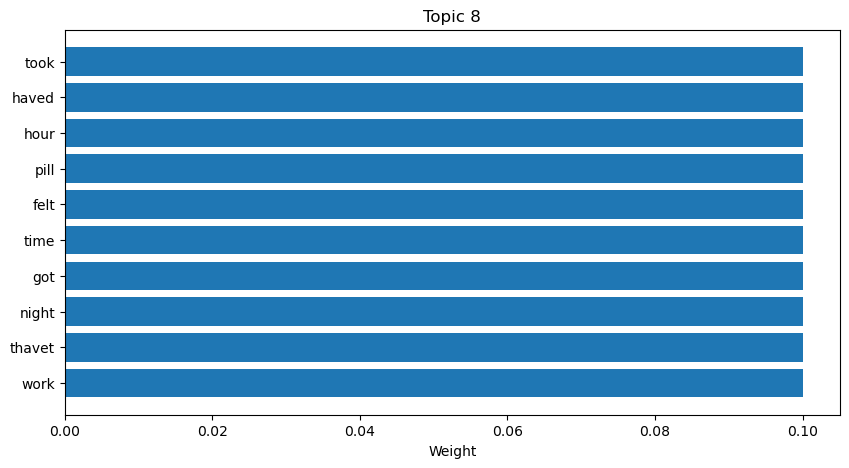

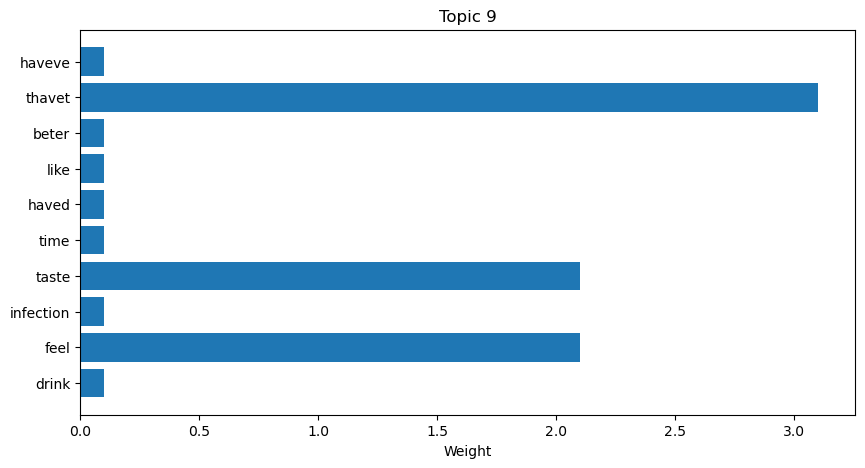

In [105]:

# Create a bar plot for keywords in each topic
def plot_keywords(lda_model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(lda_model.components_):
        keywords = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        plt.figure(figsize=(10, 5))
        plt.barh(keywords, topic[:num_words], align='center')
        plt.xlabel('Weight')
        plt.title(f'Topic {topic_idx}')
        plt.gca().invert_yaxis()  # Invert y-axis to display highest weight at the top
        plt.show()

# Plot keywords for each topic
plot_keywords(lda, feature_names)


In [136]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Assuming 'gensim_lda_model', 'corpus', and 'dictionary' are defined previously

# Visualize the topics using pyLDAvis
lda_visualization = gensimvis.prepare(gensim_lda_model, corpus, dictionary)
pyLDAvis.display(lda_visualization)

# If you're running this outside a Jupyter notebook, you can save the visualization to an HTML file
# pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')


----below need to revise:--

## 5 - Topic Modeling - PIPELINE

### 5.1 - Topic Modeling with LDA

In [352]:
def lda_sklearn(review_bow, bow_vectorizer, num_topics=10, random_state=42):
    from sklearn.decomposition import LatentDirichletAllocation as LDA

    # Apply LDA to the review bag-of-words
    lda_model = LDA(n_components=num_topics, # Number of topics
                    random_state=random_state, # Random state
                    evaluate_every=1, # Compute perplexity every iteration
                    n_jobs=-1, # Use all available CPUs
                    verbose=1) # Print progress
    lda_output = lda_model.fit_transform(review_bow)

    # Display the topics and their top words
    words = bow_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        print(f'Topic #{topic_idx}:')
        print(' '.join([words[i] for i in topic.argsort()[:-11:-1]]))
        print()

    # Log-likelihood and Perplexity Scores
    print("Log Likelihood:", lda_model.score(review_bow))
    print("Perplexity:", lda_model.perplexity(review_bow))

    return lda_model, lda_output

In [353]:
def lda_gensim(review_bow, bow_vectorizer, num_topics=10, random_state=42):
    from gensim.models import LdaModel
    from gensim.corpora import Dictionary
    from gensim.matutils import Sparse2Corpus

    # Create a gensim dictionary
    gensim_dict = Dictionary()
    gensim_dict.doc2bow(bow_vectorizer.get_feature_names_out(), allow_update=True)

    # Create a corpus from the sparse matrix
    corpus = Sparse2Corpus(review_bow, documents_columns=False)

    # Apply LDA to the corpus
    lda_model = LdaModel(
        corpus=corpus,
        id2word=gensim_dict,
        num_topics=num_topics,
        random_state=random_state,
        #update_every=1,
        #chunksize=100,
        #passes=10,
        #alpha='auto',
        #per_word_topics=True
    )

    lda_corpus = lda_model[corpus]
    lda_output = np.zeros((len(lda_corpus), lda_model.num_topics))
    for i, doc in enumerate(lda_corpus):
        for topic_idx, prob in doc:
            lda_output[i, topic_idx] = prob

    # Display the topics and their top words
    for topic_idx, topic in lda_model.print_topics():
        print(f'Topic #{topic_idx}:')
        print(topic)
        print()

    # Log-likelihood and Perplexity Scores
    print('\n')
    print("Log Likelihood:", lda_model.log_perplexity(corpus))
    print("Perplexity:", lda_model.log_perplexity(corpus))

    return lda_model, lda_output

In [354]:
#lda_model, lda_output = lda_gensim(review_bow, bow_vectorizer, num_topics=10, random_state=42)
lda_model, lda_output = lda_sklearn(review_bow, bow_vectorizer, num_topics=10, random_state=42)

NameError: name 'review_bow' is not defined

#### 5.1.1 - Evaluating Topic Modeling with LDA

In [31]:
# Coherence Score

## 6 - Clustering - PIPELINE

### 6.1 - Clustering

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [33]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=-1)
clusters = dbscan.fit_predict(lda_output)

In [34]:
# Apply K-Means
#num_clusters = 10
#kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#clusters = kmeans.fit_predict(lda_output)

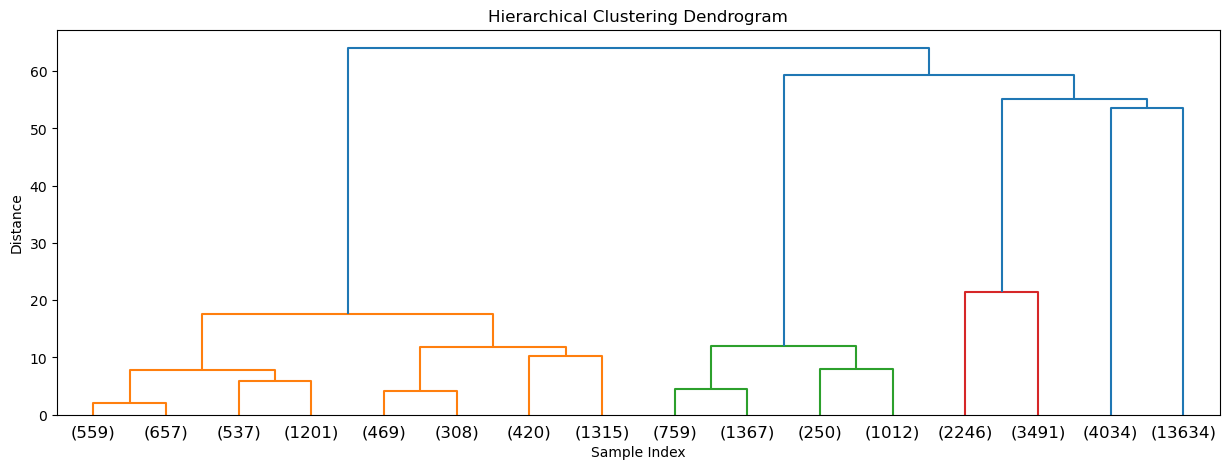

In [35]:
# Apply Hierarchical Clustering
linkage_matrix = linkage(lda_output, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 5))
dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [36]:
# Cut the dendrogram to get the clusters
max_distance = 15
clusters = fcluster(linkage_matrix, max_distance, criterion='distance')

In [37]:
# Attach cluster labels to original dataframe
X_sample['cluster'] = clusters
print(X_sample['cluster'].value_counts())
print('\n')

# Analyze the clusters
for cluster_num in np.unique(clusters):
    if cluster_num == -1:
        print(f'Cluster {cluster_num} (Outliers/Noise):')
        continue
    else:
        print(f'Cluster {cluster_num}:')
    
    print(X_sample[X_sample['cluster'] == cluster_num].iloc[:, :3].sample(5))
    print('\n')

cluster
3     3388
12    3264
1     2954
2     2512
8     2331
4     2246
13    2237
6     2053
10    2019
7     1703
14    1659
11    1496
5     1438
15    1382
9      966
16     611
Name: count, dtype: int64


Cluster 1:
              drugName               condition  \
131957      Clonazepam  Restless Legs Syndrome   
17323   Desvenlafaxine                 Obesity   
125206      Effexor XR                 Anxiety   
58195        Neurontin         Bipolar Disorde   
31118         Zonegran                Seizures   

                                                   review  
131957  "Clonazepam is very effective in controlling m...  
17323   "This medication was prescribed to me for appe...  
125206  "Started on 37.5mg for a month. First two days...  
58195                  "Is definitely a mood stabilizer!"  
31118   "Seizures decreased in frequecy.  Partial seiz...  


Cluster 2:
             drugName               condition  \
92621     Propranolol           mance Anxiety   
13364

In [38]:
dominant_topic = lda_output.argmax(axis=1)
df_document_topic = pd.DataFrame({'Dominant_Topic': dominant_topic, 'Cluster': clusters})

In [39]:
df_document_topic.groupby('Cluster')['Dominant_Topic'].agg(lambda x: x.value_counts().index[0])

Cluster
1     6
2     6
3     9
4     8
5     8
6     8
7     2
8     2
9     7
10    7
11    0
12    5
13    3
14    4
15    9
16    1
Name: Dominant_Topic, dtype: int64

#### 6.1.1 - Evaluating Topic Modeling

In [40]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [41]:
# Calculate the silhouette score
print(f'Silhouette Score: {silhouette_score(lda_output, clusters)}')

# Calculate the Davies-Bouldin score
print(f'Davies-Bouldin Score: {davies_bouldin_score(lda_output, clusters)}')

Silhouette Score: 0.2990957874256792
Davies-Bouldin Score: 1.2142116038045407


In [13]:
import pandas as pd
df = pd.read_csv('../data/preprocessed/lewtun-drug-reviews/procd_sample_train.csv')

In [14]:
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,procd_review
0,82746,Maxalt-MLT,Migraine,"""One Maxalt-MLT usually gets rid of the migrai...",9,2013-02-08,13,Maxalt MLT usually get rid migraine hour occas...
1,5530,Almotriptan,Migraine,"""Amazing results if taken early on in onset. C...",10,2008-12-02,11,amazing result take early onset believe headache
2,176287,Lorazepam,Anxiety,"""Taken it a few times/packets.. Found it did n...",8,2016-06-29,8,take time packet find med like concerta suboxo...
3,23716,Chlorzoxazone,Muscle Spasm,"""After trying dozens of muscle relaxers over t...",7,2009-05-09,28,try dozen muscle relaxer past 1 year have ef...
4,220462,Loestrin 24 Fe,Abnormal Uterine Bleeding,"""I have been on this pill which is my first bi...",10,2011-10-31,8,pill birth control pill 34 month take pill nau...
...,...,...,...,...,...,...,...,...
32255,24149,Tretinoin,Acne,"""I had cysitic acne that would pop up mainly a...",10,2014-07-02,110,cysitic acne pop mainly chin cheek dermatologi...
32256,225803,Bupropion,Depression,"""I liked Wellbutrin for the 3 weeks I was on i...",8,2011-04-26,20,like Wellbutrin 3 week feel good energetic h...
32257,87914,Clindamycin,Bacterial Infection,"""Just finished taking this, 300mg, three times...",9,2017-02-23,22,finish take 300 mg time day seven day Infect...
32258,195300,Verdeso,Eczema,"""Wonderful but expensive.""",10,2012-06-03,15,wonderful expensive
